# HR Attrition Analysis & Prediction

We're data scientists at a large company, and we've been tasked by management to determine what factors (if possible) drive attrition in our company. More importantly, we need to build an accurate model that predicts whether or not an employee is going to leave the company given certain factors.

Data Source: https://www.kaggle.com/vjchoudhary7/hr-analytics-case-study#employee_survey_data.csv


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import ListedColormap

%matplotlib inline

## Data Preparation

In [2]:
employee_survey_data = pd.read_csv("../data/hr/employee_survey_data.csv")
general_data = pd.read_csv("../data/hr/general_data.csv")
manager_survey_data = pd.read_csv("../data/hr/manager_survey_data.csv")

In [3]:
employee_survey_data = employee_survey_data.set_index("EmployeeID")
general_data = general_data.set_index("EmployeeID")
manager_survey_data = manager_survey_data.set_index("EmployeeID")

In [4]:
# make a full df which merges on the index
full_df = pd.concat([employee_survey_data, general_data, manager_survey_data], axis="columns")

See if we can't clean this up a bit. We need to make sure all of our data is numeric, and any blank rows are dropped entirely

In [5]:
# get the shape of the dataframe
full_df.shape

(4410, 28)

We have a lot of data points, but let's see how many of those are NA...

Let's first convert strings of NA to np.nan

In [6]:
# get number of rows with at least 1 NaN value in ANY column
list(full_df.isnull().sum(axis=1)).count(1)

109

In [7]:
# 109 of the 4400 or so rows have at least 1 num value
# let's drop all null values as that's only ~2% of the whole sample

In [8]:
full_df = full_df.dropna(how="any")

In [9]:
# let's convert our target class "Attrition" into the correct format. I.e. 0, 1
df = full_df.copy()

In [10]:
df["Attrition"] = df["Attrition"].apply(lambda x: 0 if x == "No" else 1)

In [11]:
# change gender to binary, in terms of Male. Male = 1, Female = 0
df["Male"] = df["Gender"].apply(lambda x: 0 if x == "Female" else 1)
df = df.drop(columns=["Gender"])

In [12]:
# change Over18 to binary. 1 if over, 0 else
df["Over18"] = df["Over18"].apply(lambda x: 0 if x=="N" else 1)

In [13]:
df.MaritalStatus.value_counts()

Married     1969
Single      1382
Divorced     949
Name: MaritalStatus, dtype: int64

In [14]:
# encode the rest of our variables
# we need to select all of the categorical variables to do this
dummify = [
    "BusinessTravel",
    "Department",
    "DistanceFromHome",
    "EducationField",
    "JobRole",
    "MaritalStatus",
]

for dummy in dummify:
    df = pd.concat([df, pd.get_dummies(df[dummy], drop_first=True)], axis="columns")

df = df.drop(columns=dummify)

In [15]:
df.shape

(4300, 69)

Now we have a lot more columns! 68 features, +1 if we include the target

## Data Exploration

Before we start to model our data, it is imperative that we look into the distribution of features. I'm curious to see which items stand out. First and foremost, let's just compute a simple correlation heatmap to get a sense of the initial feature correlation...

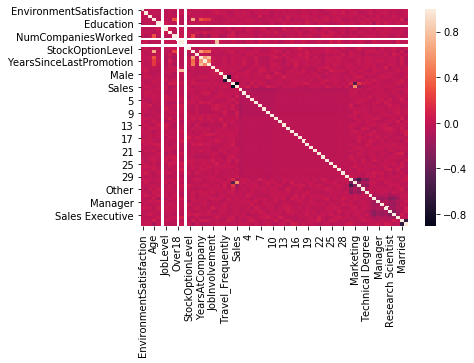

In [16]:
sns.heatmap(df.drop(columns=["Attrition"]).corr())

We can't see much from this data yet, but we can see there might be a high correlation between items like `YearsSinceLastPromotion` and `YearsAtCompany` (which makes a bit of sense).

Let's refine this correlation to only include numerical columns that we might initially use in a model.

In [17]:
refined_columns_of_interest = [
    "Age",
    "JobLevel",
    "MonthlyIncome",
    "NumCompaniesWorked",
    "StandardHours",
    "TotalWorkingYears",
    "YearsAtCompany",
    "Education",
    "StockOptionLevel",
    "TrainingTimesLastYear",
    "YearsSinceLastPromotion",
    "YearsWithCurrManager",
    "PerformanceRating", # manager based stuff
    "JobInvolvement",
    "Attrition"
]

refined_df = df[refined_columns_of_interest]

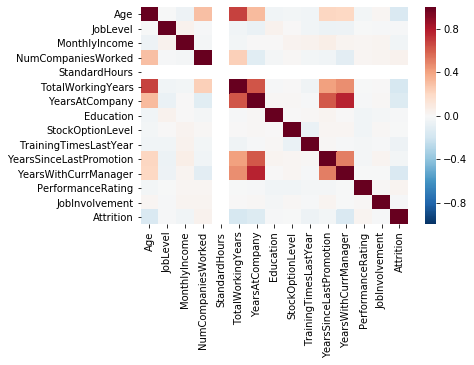

In [18]:
sns.heatmap(refined_df.corr(), vmax=1, vmin=-1, cmap=sns.color_palette("RdBu_r", 1000))

From the heatmap above we see a few things...

Attrition seems to be slightly negatively correlated with Age, TotalWorkingYears and YearsAtCompany. This should come as no suprise

We have pretty low correlated in either direction for the rest of the features. This isn't that suprising.

Let's look at some distributions though to see if we see any weird outliers

In [19]:
# checking for class imbalance

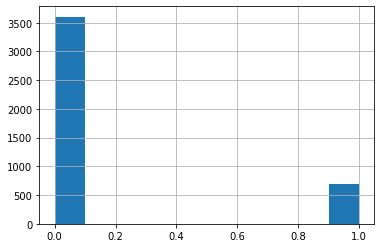

In [20]:
df.Attrition.hist()

As I expected, since we're measuring a minority occuring event, we would most certainly have a class imbalance problem.

Let's measure how bad it is, and see if we need to re-sample

In [21]:
attrition_yes = len(df[df.Attrition == 1])
attrition_no = len(df[df.Attrition == 0])
print(attrition_yes)
print(attrition_no)

695
3605


In [22]:
# looks like our minority class is 16% that of our whole sample.

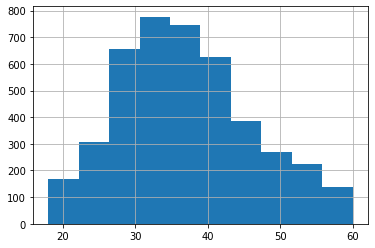

In [23]:
df.Age.hist()

In [24]:
# NOTE: Normalize the Age variable later

In [25]:
# import SMOTE & train_test_split function to upsample the dataset
# as well as some other machine learning tools
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

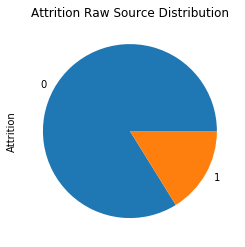

In [26]:
# plot distribution of 1 to 0 for trait == atrition

_ = df.Attrition.value_counts().plot.pie(title="Attrition Raw Source Distribution")

In [27]:
# ad-hoc
from sklearn.preprocessing import scale
# create our train test split set
features = df.drop(columns=["Attrition"])
target = df["Attrition"]

scaled_features = scale(features)

# train test split
X_train, X_test, y_train, y_test = train_test_split(scaled_features, target, test_size=0.25, random_state=23)

/Users/ryan/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by the scale function.
  import sys


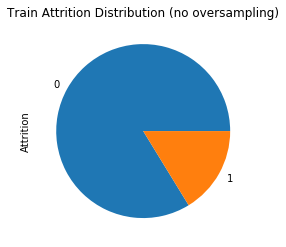

In [28]:
# plot the dist of train 1s vs 0s for attrition
_ = y_train.value_counts().plot.pie(title="Train Attrition Distribution (no oversampling)")

### Correcting Class Imbalance using minority oversampling

Due to the general class imbalance within our dataset, it's important to remove this bias in order for our testing data to be accurately classified. We'll attempt to do this using SMOTE upsampling (oversampling), targeting our training dataset. *More on why we only use the training set in a second...*

In [29]:
smote_oversampler = SMOTE(sampling_strategy=1.0)

# fit and resample

X_train_resample, y_train_resample = smote_oversampler.fit_resample(X_train, y_train)

# convert back to a dataframe & series, respectively
X_train_resample = pd.DataFrame(X_train_resample, columns=features.columns)
y_train_resample = pd.Series(y_train_resample, name="Attrition")

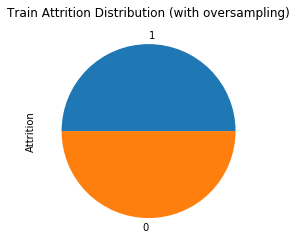

In [30]:
# plot the distribution of attrition value counts now
y_train_resample.value_counts().plot.pie(title="Train Attrition Distribution (with oversampling)")

In [31]:
X_train_resample.shape

(5402, 68)

In [32]:
from sklearn.metrics import average_precision_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from sklearn.metrics import auc
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from inspect import signature

def create_auprc_curve(y_test, y_score, title_prefix="model"):
    average_precision = average_precision_score(y_test, y_score)
    
    precision, recall, _ = precision_recall_curve(y_test, y_score)

    # In matplotlib < 1.5, plt.fill_between does not have a 'step' argument
    step_kwargs = ({'step': 'post'}
                   if 'step' in signature(plt.fill_between).parameters
                   else {})
    plt.step(recall, precision, color='b', alpha=0.2,
             where='post')
    plt.fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title('2-class Precision-Recall curve for {}: AP={}'.format(
            title_prefix,
            round(average_precision, 2)))
    plt.show()

In [33]:
def create_roc_curve(y_test, y_score, title_prefix="model"):
    
    false_positive_rate, true_positive_rate, _ = roc_curve(y_test, y_score)
    
    # find the area under the roc curve
    auc_score = auc(false_positive_rate, true_positive_rate)
    
    # now plot the curve
    plt.figure()
    lw = 2
    plt.plot(false_positive_rate, true_positive_rate, color='darkred',
             lw=lw, label='ROC curve (area = %0.2f)' % auc_score)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('2-Class ROC for {}'.format(title_prefix))
    plt.legend(loc="lower right")
    plt.show()

In [34]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier

models = {}

# create some models to start
# create a logistic regression model
lr = LogisticRegression(solver="liblinear", penalty="l1")

models["Logistic Regression"] = lr

# create a SVC
svc_model_auto = SVC(gamma="auto")

models["SVC Auto"] = svc_model_auto

svc_model_scale = SVC(gamma="scale")
models["SVC Scale"] = svc_model_scale

# create the ada booster classifier
ada_model = AdaBoostClassifier(n_estimators=100)

models["AdaBoost"] = ada_model


# create a gradient booster model
gbc_model = GradientBoostingClassifier()

models["Gradient Boosting"] = gbc_model


In [35]:
def evaluate_models(models, X_train, X_test, y_train, y_test):
    """Performs classification using the provided `models` and the data provided.
    
    Plots AUPRC & AUCROC curves with scores for each model
    
    Parameters
    ----------
    
    models : dict
        A key-value pair of models, where the key is the name of the classifier,
        and the value is the model instance
    ...
    
    
    """
    
    for name, model in models.items():
        # first train the model on the train set
        model.fit(X_train, y_train)
        
        # get decision function
        y_score = model.decision_function(X_test)
        y_pred = model.predict(X_test)
        
        create_auprc_curve(y_test, y_score, title_prefix=name)
        
        create_roc_curve(y_test, y_score, title_prefix=name)
        
        sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, cmap="RdBu", fmt="d")
        plt.show()
        
        
        # compute the raw train & test score for the classifier
        
        train_score = model.score(X_train, y_train)
        print("Train score for {}: {}".format(name, train_score))
        
        test_score = model.score(X_test, y_test)
        print("Test score for {}: {}".format(name, test_score))
        
        # compute the mean cv score
        cross_validation_score = cross_val_score(model, X_test, y_test, cv=20)
        print("Mean Test Cross Val score (k=20) for {}: {}".format(name, cross_validation_score.mean()))
    
        if hasattr(model, "_gamma"):
            print("Gamma: {}".format(model._gamma))
    

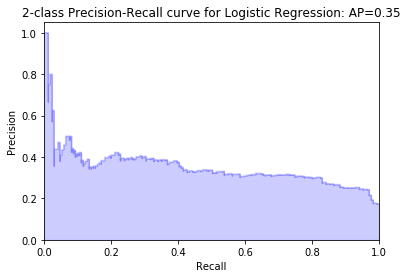

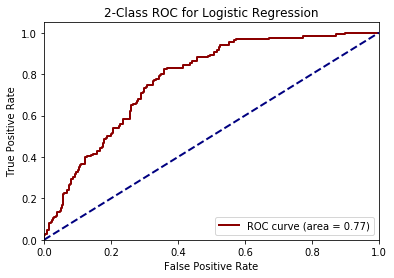

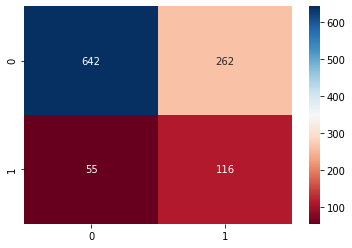

Train score for Logistic Regression: 0.7569418733802296
Test score for Logistic Regression: 0.7051162790697675
Mean Test Cross Val score (k=20) for Logistic Regression: 0.8476672384219555


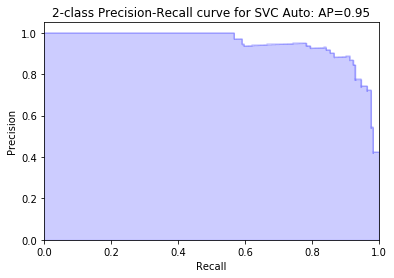

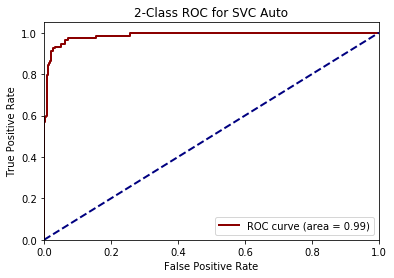

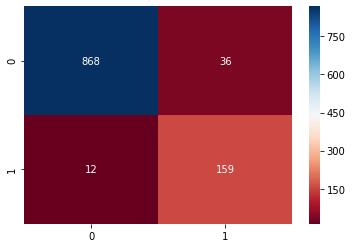

Train score for SVC Auto: 0.9896334690855239
Test score for SVC Auto: 0.9553488372093023
Mean Test Cross Val score (k=20) for SVC Auto: 0.8624865002223492
Gamma: 0.014705882352941176


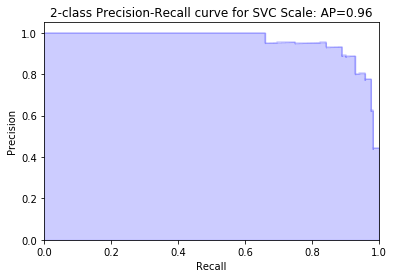

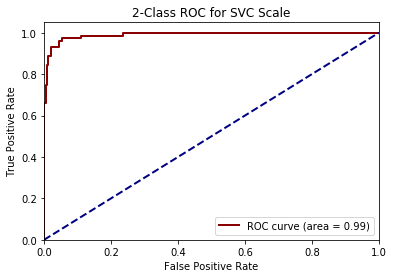

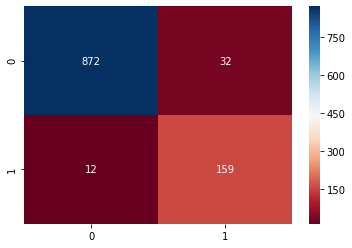

Train score for SVC Scale: 0.9933358015549797
Test score for SVC Scale: 0.9590697674418605
Mean Test Cross Val score (k=20) for SVC Scale: 0.8624865002223492
Gamma: 0.016041659468248756


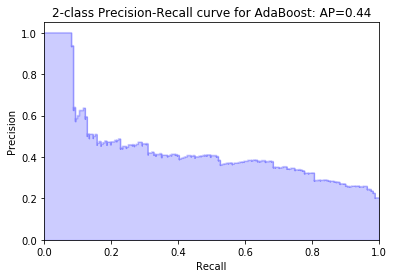

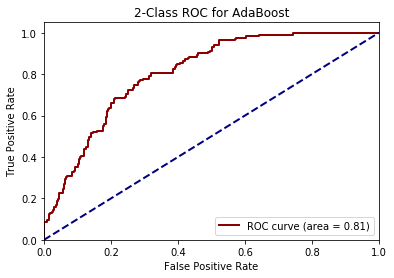

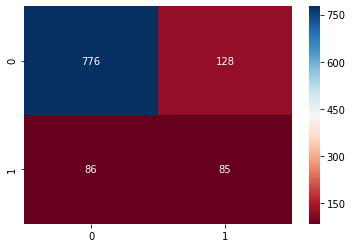

Train score for AdaBoost: 0.8591262495372084
Test score for AdaBoost: 0.8009302325581396
Mean Test Cross Val score (k=20) for AdaBoost: 0.8457124706181309


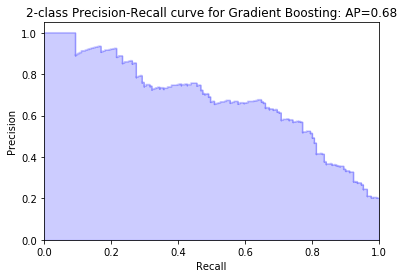

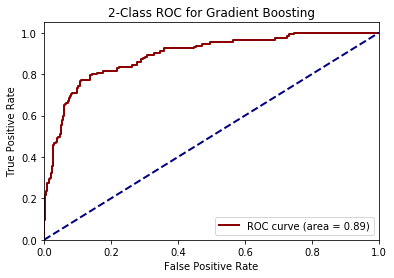

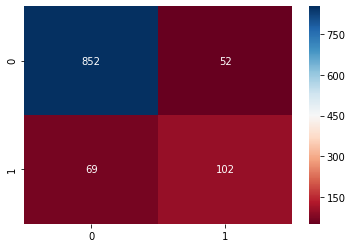

Train score for Gradient Boosting: 0.9120696038504258
Test score for Gradient Boosting: 0.8874418604651163
Mean Test Cross Val score (k=20) for Gradient Boosting: 0.8735483768502638


In [36]:
evaluate_models(models, X_train_resample, X_test, y_train_resample, y_test)